In [1]:
import pandas as pd

# 전처리 CSV 파일 불러오기 
df = pd.read_csv('wildfire_preprocessed_V1.csv')

In [2]:
df.head()

,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_SE,WNDRCT_BRNG_SW,WNDRCT_BRNG_NE,WNDRCT_BRNG_NW,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12


In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
# 파일 경로
CSV_PATH = "wildfire_preprocessed_V1.csv"

# 예측 시점 선택에 따라 누수 변수 포함/제외 토글
# True  -> 도착 이후 시점(허용),  ARRIVAL_DELAY_MIN_LOG 포함
# False -> 발생 직후 시점(비허용), ARRIVAL_DELAY_MIN_LOG 제외
INCLUDE_LEAKY = True

# 데이터 로드
df = pd.read_csv(CSV_PATH)

print(f"행: {len(df):,}, 열: {len(df.columns)}")
print("\n컬럼명:\n", df.columns.tolist()[:50], " ...")
display(df.head())

# 타깃/피처 선택
TARGET = "FIRE_SUPESN_HR"
if TARGET not in df.columns:
    raise ValueError(f"'{TARGET}' 컬럼이 없습니다.")

# 모델에서 제외할 컬럼(있으면 제거)
EXCLUDE_COLS = {
    "total_time", "fire_supesn_hr", "relax_diff", "wind_speed_mean",
    TARGET  # 타깃은 당연히 피처에서 제외
}

# 숫자형 컬럼만 사용(원-핫 완료 가정) + 제외 컬럼 제거
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in EXCLUDE_COLS]

# 필요 시 누수 변수 제거 (새 데이터에 없으면 자동 무시)
LEAKY_COL = "ARRIVAL_DELAY_MIN_LOG"
if not INCLUDE_LEAKY and LEAKY_COL in feature_cols:
    feature_cols.remove(LEAKY_COL)

# 안전장치: 피처가 하나도 없으면 에러
if len(feature_cols) == 0:
    raise ValueError("선택된 피처가 없습니다. EXCLUDE_COLS 또는 전처리를 확인하세요.")

print(f"선택된 피처 수: {len(feature_cols)}")
print("제외된 컬럼(데이터에 존재했던 항목만):",
      sorted([c for c in EXCLUDE_COLS if c in df.columns]))

X = df[feature_cols].copy()
y = df[TARGET].copy()

# 결측치 처리(있으면 행 제거)
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"\n최종 데이터 크기: X={X.shape}, y={y.shape}")
print(f"누수 변수 포함 여부(INCLUDE_LEAKY) = {INCLUDE_LEAKY}")


행: 3,359, 열: 66

컬럼명:
 ['DSPT_REQ_HR', 'FIRE_SUPESN_HR', 'FRSTN_GRNDS_DSTNC', 'CNTR_GRNDS_DSTNC', 'HR_UNIT_ARTMP', 'HR_UNIT_HUM', 'WSPD_BIN', 'MONTH', 'CMBS_EXPOBJ_LCLSF_NM_unknown', 'CMBS_EXPOBJ_LCLSF_NM_GAS', 'CMBS_EXPOBJ_LCLSF_NM_ETC', 'CMBS_EXPOBJ_LCLSF_NM_GARBAGE', 'CMBS_EXPOBJ_LCLSF_NM_DANGER', 'CMBS_EXPOBJ_LCLSF_NM_VEHICLE_TRAIN_SHIP_AIRCRAFT', 'CMBS_EXPOBJ_LCLSF_NM_ELEC', 'CMBS_EXPOBJ_LCLSF_NM_PAPER_WOOD', 'CMBS_EXPOBJ_LCLSF_NM_BED_WOOL', 'CMBS_EXPOBJ_LCLSF_NM_PLASTIC', 'CMBS_EXPOBJ_LCLSF_NM_nan', 'IGTN_HTSRC_NM_ETC', 'IGTN_HTSRC_NM_SMOKE', 'IGTN_HTSRC_NM_FRICTION', 'IGTN_HTSRC_NM_unknown', 'IGTN_HTSRC_NM_SPARK', 'IGTN_HTSRC_NM_NATURAL', 'IGTN_HTSRC_NM_MACHINE', 'IGTN_HTSRC_NM_EXPLOSIVE', 'IGTN_HTSRC_NM_CHEMICAL', 'CTPV_NM_busan', 'CTPV_NM_chungbuk', 'CTPV_NM_chungnam', 'CTPV_NM_daegu', 'CTPV_NM_daejeon', 'CTPV_NM_gangwon', 'CTPV_NM_gwangju', 'CTPV_NM_gyeongbuk', 'CTPV_NM_gyeonggi', 'CTPV_NM_gyeongnam', 'CTPV_NM_incheon', 'CTPV_NM_jeju', 'CTPV_NM_jeonbuk', 'CTPV_NM_jeonnam', 'C

,DSPT_REQ_HR,FIRE_SUPESN_HR,FRSTN_GRNDS_DSTNC,CNTR_GRNDS_DSTNC,HR_UNIT_ARTMP,HR_UNIT_HUM,WSPD_BIN,MONTH,CMBS_EXPOBJ_LCLSF_NM_unknown,CMBS_EXPOBJ_LCLSF_NM_GAS,...,WNDRCT_BRNG_west,WNDRCT_BRNG_SE,WNDRCT_BRNG_SW,WNDRCT_BRNG_NE,WNDRCT_BRNG_NW,dispatch_time_diff,arrival_time_diff,golden_time_under_50min,is_night,month_rcpt
0,5.509388,7.090910,2.484907,1.609438,-1.0,39.0,1,1,0,0,...,0,0,0,0,1,4.521789,5.823046,1,1,1
1,5.537334,6.398595,1.609438,1.098612,5.0,60.0,1,3,0,0,...,0,0,1,0,0,3.663562,5.676754,1,1,3
2,6.467699,7.284821,2.302585,1.791759,7.0,49.0,1,3,0,0,...,0,0,1,0,0,3.526361,6.517671,1,1,3
3,6.361302,7.333023,1.791759,1.098612,0.3,48.0,3,3,0,0,...,0,0,0,0,1,4.077537,6.456770,1,0,3
4,6.774224,9.579487,3.295837,2.397895,-8.7,36.0,5,12,0,0,...,1,0,0,0,0,3.496508,6.810142,1,1,12


선택된 피처 수: 65
제외된 컬럼(데이터에 존재했던 항목만): ['FIRE_SUPESN_HR']

최종 데이터 크기: X=(3359, 65), y=(3359,)
누수 변수 포함 여부(INCLUDE_LEAKY) = True


In [5]:
# === 0) 기본 설정 & Train/Test 분리 ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 전제: X, y 가 이미 준비되어 있음 (pandas DataFrame / Series 권장)
assert 'X' in globals() and 'y' in globals(), "먼저 X, y를 준비하세요."

RANDOM_STATE = 42
TEST_SIZE    = 0.2      # 80/20 분리
TARGET_IS_LOG = True    # y가 log1p 스케일이면 True (expm1로 복원용)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}  Test: {X_test.shape}")


Train: (2687, 65)  Test: (672, 65)


In [6]:
# === 1) 하이퍼파라미터 최적화 (Train 전용, 5-fold CV, 선형모델) ===
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# --- OLS (튜닝 없음) ---
def optimize_hyperparameters_ols(X_tr, y_tr):
    """
    OLS은 하이퍼파라미터가 없음. Train에 적합만 하고 빈 dict 반환.
    """
    print("=== [Step 1] OLS: 튜닝 없음 (Train 전용 적합) ===")
    ols = LinearRegression()
    ols.fit(X_tr, y_tr)
    best_params = {}  # 튜닝 파라미터 없음
    print("OLS 완료 (하이퍼파라미터 없음)")
    return best_params, ols  # 원하면 모델도 함께 반환

# --- Ridge ---
def optimize_hyperparameters_ridge(X_tr, y_tr, random_state=42):
    """
    Ridge 하이퍼파라미터(alpha) 그리드 탐색 (5-fold, MSE 기준)
    표준화 필수 → 파이프라인으로 포함
    """
    print("=== [Step 1] Ridge 하이퍼파라미터 최적화 (Train 전용) ===")
    pipe = make_pipeline(StandardScaler(with_mean=True), Ridge(random_state=random_state))
    param_grid = {
        "ridge__alpha": np.logspace(-4, 3, 8)  # 1e-4 ~ 1e3 (8개)
    }
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)
    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터 (Ridge): {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")
    return best_params, gscv.best_estimator_

# --- Lasso ---
def optimize_hyperparameters_lasso(X_tr, y_tr, random_state=42):
    """
    Lasso 하이퍼파라미터(alpha) 그리드 탐색 (5-fold, MSE 기준)
    표준화 필수 → 파이프라인으로 포함
    """
    print("=== [Step 1] Lasso 하이퍼파라미터 최적화 (Train 전용) ===")
    pipe = make_pipeline(StandardScaler(with_mean=True), Lasso(max_iter=20000, random_state=random_state))
    param_grid = {
        "lasso__alpha": np.logspace(-4, 1, 10)  # 1e-4 ~ 10 (10개)
    }
    gscv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        verbose=1,
        refit=True,
    )
    gscv.fit(X_tr, y_tr)
    best_params = gscv.best_params_
    best_mse = -gscv.best_score_
    print(f"\n최적 하이퍼파라미터 (Lasso): {best_params}")
    print(f"최적 CV MSE: {best_mse:,.6f} (RMSE={np.sqrt(best_mse):,.6f})")
    return best_params, gscv.best_estimator_

best_params_ols,   best_model_ols   = optimize_hyperparameters_ols(X_train, y_train)
best_params_ridge, best_model_ridge = optimize_hyperparameters_ridge(X_train, y_train, random_state=RANDOM_STATE)
best_params_lasso, best_model_lasso = optimize_hyperparameters_lasso(X_train, y_train, random_state=RANDOM_STATE)

print("\n[Step 1 결과]")
print("OLS params :", best_params_ols)
print("Ridge params:", best_params_ridge)
print("Lasso params:", best_params_lasso)


=== [Step 1] OLS: 튜닝 없음 (Train 전용 적합) ===
OLS 완료 (하이퍼파라미터 없음)
=== [Step 1] Ridge 하이퍼파라미터 최적화 (Train 전용) ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits

최적 하이퍼파라미터 (Ridge): {'ridge__alpha': np.float64(1000.0)}
최적 CV MSE: 1.761590 (RMSE=1.327249)
=== [Step 1] Lasso 하이퍼파라미터 최적화 (Train 전용) ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits

최적 하이퍼파라미터 (Lasso): {'lasso__alpha': np.float64(0.016681005372000592)}
최적 CV MSE: 1.764021 (RMSE=1.328165)

[Step 1 결과]
OLS params : {}
Ridge params: {'ridge__alpha': np.float64(1000.0)}
Lasso params: {'lasso__alpha': np.float64(0.016681005372000592)}


In [7]:
# === 2) 고정 하이퍼파라미터로 10번 반복(CV=5) → 베스트 run 선택 (OLS/Ridge/Lasso) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Step 1에서 얻은 best_params_* 사용
# best_params_ols, best_params_ridge, best_params_lasso 가 이미 존재한다고 가정

def _extract_alpha(best_params, prefix):
    k = f"{prefix}__alpha"
    return None if best_params is None else best_params.get(k, None)

def _build_model(model_type, best_params, seed):
    if model_type == "OLS":
        return LinearRegression()
    if model_type == "Ridge":
        alpha = _extract_alpha(best_params, "ridge") or 1.0
        return make_pipeline(StandardScaler(with_mean=True),
                             Ridge(alpha=alpha, random_state=seed))
    if model_type == "Lasso":
        alpha = _extract_alpha(best_params, "lasso") or 0.001
        return make_pipeline(StandardScaler(with_mean=True),
                             Lasso(alpha=alpha, max_iter=20000, random_state=seed))
    raise ValueError("model_type must be 'OLS'|'Ridge'|'Lasso'")

def pick_best_model_over_runs_linear(
    X_tr, y_tr, model_type, best_params,
    n_runs=10, n_splits=5, base_seed=1000
):
    print(f"\n=== [Step 2] 10번 반복 CV → 베스트 run 선택 ({model_type}) ===")
    run_summaries = []
    best_idx, best_cv_mse = None, np.inf
    seeds = [base_seed + i for i in range(n_runs)]

    for i, seed in enumerate(seeds, start=1):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
        fold_mse = []
        for tr_idx, va_idx in kf.split(X_tr):
            Xf_tr, Xf_va = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
            yf_tr, yf_va = y_tr.iloc[tr_idx], y_tr.iloc[va_idx]
            model = _build_model(model_type, best_params, seed)
            model.fit(Xf_tr, yf_tr)
            pred = model.predict(Xf_va)
            fold_mse.append(mean_squared_error(yf_va, pred))
        cv_mse = float(np.mean(fold_mse))
        cv_rmse = float(np.sqrt(cv_mse))
        run_summaries.append((seed, cv_mse, cv_rmse))
        print(f"[Run {i:02d} | seed={seed}] CV MSE={cv_mse:.6f} (RMSE={cv_rmse:.6f})")
        if cv_mse < best_cv_mse:
            best_cv_mse, best_idx = cv_mse, i-1

    best_seed, best_mse, best_rmse = run_summaries[best_idx]
    print(f"\n>>> 베스트 run: #{best_idx+1} (seed={best_seed}) "
          f"CV MSE={best_mse:.6f} (RMSE={best_rmse:.6f})")

    # 베스트 seed로 Train 전체 재학습
    best_model = _build_model(model_type, best_params, best_seed)
    best_model.fit(X_tr, y_tr)
    return best_model, run_summaries

# 실행 (세 모델 모두)
best_model_ols,   runs_ols   = pick_best_model_over_runs_linear(X_train, y_train, "OLS",   best_params_ols)
best_model_ridge, runs_ridge = pick_best_model_over_runs_linear(X_train, y_train, "Ridge", best_params_ridge)
best_model_lasso, runs_lasso = pick_best_model_over_runs_linear(X_train, y_train, "Lasso", best_params_lasso)



=== [Step 2] 10번 반복 CV → 베스트 run 선택 (OLS) ===
[Run 01 | seed=1000] CV MSE=1.783573 (RMSE=1.335505)
[Run 02 | seed=1001] CV MSE=1.765305 (RMSE=1.328648)
[Run 03 | seed=1002] CV MSE=1.760922 (RMSE=1.326997)
[Run 04 | seed=1003] CV MSE=1.764305 (RMSE=1.328271)
[Run 05 | seed=1004] CV MSE=1.779051 (RMSE=1.333811)
[Run 06 | seed=1005] CV MSE=1.760770 (RMSE=1.326940)
[Run 07 | seed=1006] CV MSE=1.788018 (RMSE=1.337168)
[Run 08 | seed=1007] CV MSE=1.767008 (RMSE=1.329289)
[Run 09 | seed=1008] CV MSE=1.780432 (RMSE=1.334328)
[Run 10 | seed=1009] CV MSE=1.791834 (RMSE=1.338594)

>>> 베스트 run: #6 (seed=1005) CV MSE=1.760770 (RMSE=1.326940)

=== [Step 2] 10번 반복 CV → 베스트 run 선택 (Ridge) ===
[Run 01 | seed=1000] CV MSE=1.769977 (RMSE=1.330405)
[Run 02 | seed=1001] CV MSE=1.756149 (RMSE=1.325198)
[Run 03 | seed=1002] CV MSE=1.754563 (RMSE=1.324599)
[Run 04 | seed=1003] CV MSE=1.756457 (RMSE=1.325314)
[Run 05 | seed=1004] CV MSE=1.764840 (RMSE=1.328473)
[Run 06 | seed=1005] CV MSE=1.744713 (RMSE=1.320

In [8]:
# === 3) 선형모델 3개(OLS/Ridge/Lasso) Test 평가 (로그/원 단위) ===
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_one(best_model, X_te, y_te, label, target_is_log=True, time_unit="min", show_both=True):
    """단일 모델 평가 (로그/원 단위) + 결과 dict 반환"""
    def to_unit(v_sec, unit="sec"):
        if unit == "min":  return v_sec / 60.0
        if unit == "hour": return v_sec / 3600.0
        return v_sec
    def unit_label(unit):
        return {"sec":"초", "min":"분", "hour":"시간"}[unit]
    def hhmm(v_sec):
        v_sec = float(v_sec); h = int(v_sec // 3600); m = int((v_sec % 3600) // 60)
        return f"{h}h {m}m"
    def show(name, v_sec):
        main = to_unit(v_sec, time_unit)
        s = f"{name}: {main:,.2f} {unit_label(time_unit)}"
        if show_both:
            other = {"sec":"min", "min":"hour", "hour":"min"}[time_unit]
            s += f"  |  ({to_unit(v_sec, other):,.2f} {unit_label(other)}, ~{hhmm(v_sec)})"
        return s

    # 로그 스케일 지표
    y_pred_log = best_model.predict(X_te)
    rmse_log = float(np.sqrt(mean_squared_error(y_te, y_pred_log)))
    mae_log  = float(mean_absolute_error(y_te, y_pred_log))
    r2_log   = float(r2_score(y_te, y_pred_log))
    print(f"\n=== [Step 3] Test 성능 — 로그 스케일 ({label}) ===")
    print(f"RMSE={rmse_log:.4f}  MAE={mae_log:.4f}  R²={r2_log:.4f}")

    # 원 단위 지표
    if target_is_log:
        y_true_o = np.expm1(y_te)
        y_pred_o = np.expm1(y_pred_log)
    else:
        y_true_o = y_te
        y_pred_o = y_pred_log

    rmse_o = float(np.sqrt(mean_squared_error(y_true_o, y_pred_o)))
    mae_o  = float(mean_absolute_error(y_true_o, y_pred_o))
    r2_o   = float(r2_score(y_true_o, y_pred_o))

    print(f"\n=== Test 성능 — 원 단위 ({label}) ===")
    print(show("RMSE", rmse_o))
    print(show("MAE",  mae_o))
    print(f"R²  : {r2_o:.4f}  (역변환 후 R²는 참고용)")

    return {
        "model": label,
        "log_RMSE": rmse_log, "log_MAE": mae_log, "log_R2": r2_log,
        "orig_RMSE": rmse_o, "orig_MAE": mae_o, "orig_R2": r2_o
    }

def evaluate_linear_models_on_test(models_dict, X_test, y_test, target_is_log=True, time_unit="min", show_both=True):
    """
    models_dict 예:
      {
        "OLS": best_model_ols,
        "Ridge": best_model_ridge,
        "Lasso": best_model_lasso,
      }
    """
    summaries = []
    for name, model in models_dict.items():
        summaries.append(
            evaluate_one(model, X_test, y_test, label=name,
                         target_is_log=target_is_log, time_unit=time_unit, show_both=show_both)
        )
    df = pd.DataFrame(summaries).sort_values("orig_RMSE")
    print("\n=== 모델별 Test 성능 요약 (원 단위 RMSE 오름차순) ===")
    display(df)
    return df

# 실행 예시 (Step 2에서 만든 모델 변수명을 사용하세요)
models = {
    "OLS": best_model_ols,
    "Ridge": best_model_ridge,
    "Lasso": best_model_lasso,
}
df_summary = evaluate_linear_models_on_test(models, X_test, y_test,
                                            target_is_log=TARGET_IS_LOG, time_unit="min", show_both=True)



=== [Step 3] Test 성능 — 로그 스케일 (OLS) ===
RMSE=1.2808  MAE=0.8588  R²=0.1933

=== Test 성능 — 원 단위 (OLS) ===
RMSE: 152.47 분  |  (2.54 시간, ~2h 32m)
MAE: 67.03 분  |  (1.12 시간, ~1h 7m)
R²  : 0.0355  (역변환 후 R²는 참고용)

=== [Step 3] Test 성능 — 로그 스케일 (Ridge) ===
RMSE=1.2871  MAE=0.8635  R²=0.1853

=== Test 성능 — 원 단위 (Ridge) ===
RMSE: 154.21 분  |  (2.57 시간, ~2h 34m)
MAE: 67.14 분  |  (1.12 시간, ~1h 7m)
R²  : 0.0135  (역변환 후 R²는 참고용)

=== [Step 3] Test 성능 — 로그 스케일 (Lasso) ===
RMSE=1.2838  MAE=0.8604  R²=0.1894

=== Test 성능 — 원 단위 (Lasso) ===
RMSE: 154.11 분  |  (2.57 시간, ~2h 34m)
MAE: 67.04 분  |  (1.12 시간, ~1h 7m)
R²  : 0.0148  (역변환 후 R²는 참고용)

=== 모델별 Test 성능 요약 (원 단위 RMSE 오름차순) ===


,model,log_RMSE,log_MAE,log_R2,orig_RMSE,orig_MAE,orig_R2
0,OLS,1.280753,0.858839,0.193310,9148.366229,4021.739966,0.035538
2,Lasso,1.283824,0.860394,0.189436,9246.389567,4022.568919,0.014759
1,Ridge,1.287097,0.863492,0.185297,9252.528443,4028.286911,0.013451



Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,CMBS_EXPOBJ_LCLSF_NM_VEHICLE_TRAIN_SHIP_AIRCRAFT,-1.107229,1.107229,-1
1,MONTH,-1.052308,1.052308,-1
2,month_rcpt,1.029061,1.029061,1
3,CMBS_EXPOBJ_LCLSF_NM_BED_WOOL,-0.708741,0.708741,-1
4,golden_time_under_50min,0.693283,0.693283,1
5,CMBS_EXPOBJ_LCLSF_NM_ELEC,0.540807,0.540807,1
6,CTPV_NM_jeonbuk,0.491582,0.491582,1
7,CTPV_NM_ulsan,-0.457357,0.457357,-1
8,CTPV_NM_busan,-0.445054,0.445054,-1
9,CTPV_NM_jeonnam,0.437182,0.437182,1


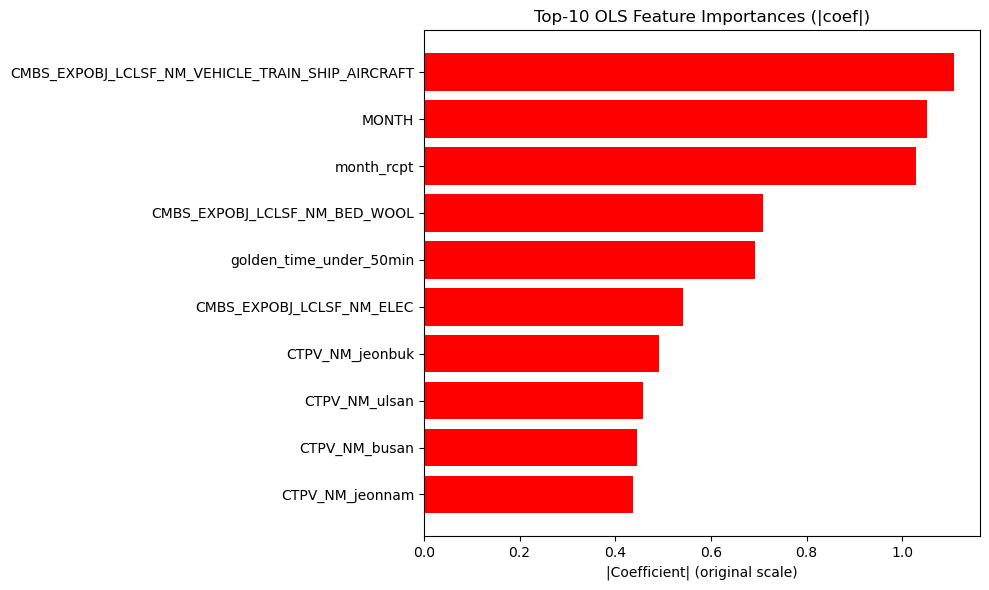


Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,CMBS_EXPOBJ_LCLSF_NM_VEHICLE_TRAIN_SHIP_AIRCRAFT,-0.812502,0.812502,-1
1,CMBS_EXPOBJ_LCLSF_NM_BED_WOOL,-0.514433,0.514433,-1
2,golden_time_under_50min,0.443378,0.443378,1
3,CTPV_NM_ulsan,-0.395072,0.395072,-1
4,CTPV_NM_busan,-0.383508,0.383508,-1
5,CTPV_NM_gyeonggi,-0.341240,0.341240,-1
6,IGTN_HTSRC_NM_CHEMICAL,0.332517,0.332517,1
7,CTPV_NM_daejeon,-0.308781,0.308781,-1
8,CTPV_NM_jeonbuk,0.307224,0.307224,1
9,CTPV_NM_daegu,-0.305874,0.305874,-1


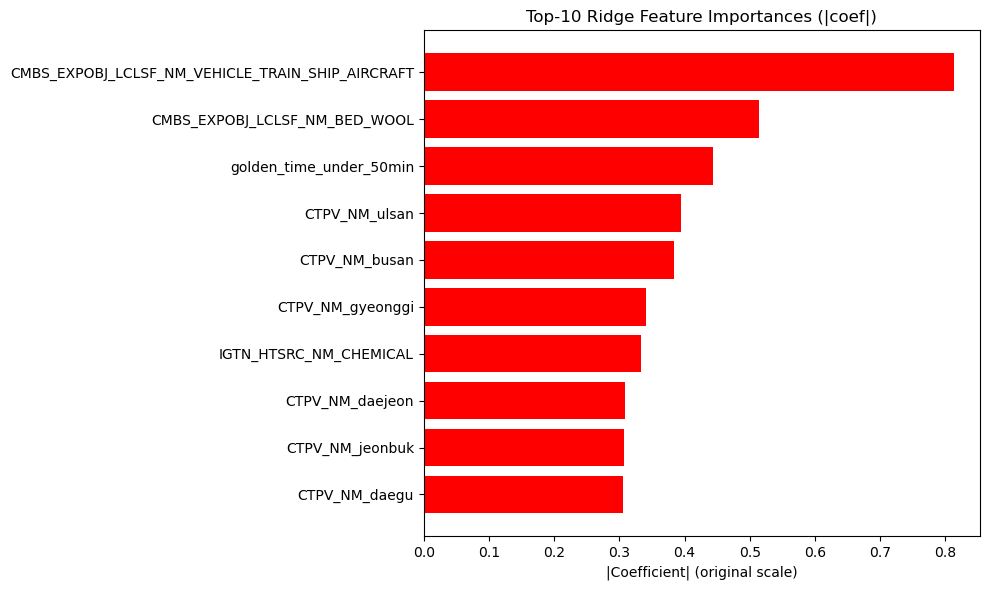


Top-10 Feature Importances (|coef|):


,feature,coef,abs_coef,sign
0,CTPV_NM_ulsan,-0.491471,0.491471,-1
1,CTPV_NM_busan,-0.476910,0.476910,-1
2,CTPV_NM_gyeonggi,-0.469433,0.469433,-1
3,FND_IGTN_PSTN_NM_plain,-0.468154,0.468154,-1
4,CMBS_EXPOBJ_LCLSF_NM_VEHICLE_TRAIN_SHIP_AIRCRAFT,-0.435533,0.435533,-1
5,golden_time_under_50min,0.380743,0.380743,1
6,CMBS_EXPOBJ_LCLSF_NM_nan,-0.363237,0.363237,-1
7,CTPV_NM_daegu,-0.350393,0.350393,-1
8,FND_IGTN_PSTN_NM_under,-0.332316,0.332316,-1
9,CTPV_NM_daejeon,-0.303050,0.303050,-1


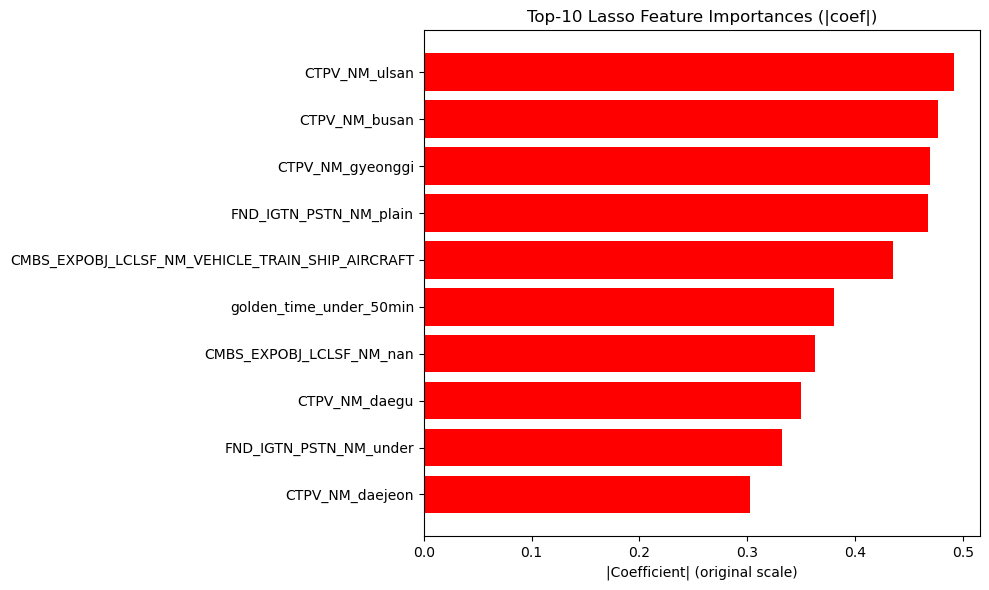

In [10]:
# === 4) 선형모델(OLS/Ridge/Lasso) 특성 중요도 Top-10 (|coef| 기준, 원 스케일) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

def _extract_linear_and_scaler(model):
    """Pipeline(StandardScaler → Linear) 또는 단일 Linear 모델에서 (linear, scaler) 추출"""
    if isinstance(model, Pipeline):
        # 마지막 스텝이 선형모델인지 확인
        last_est = model.steps[-1][1]
        if not isinstance(last_est, (LinearRegression, Ridge, Lasso)):
            raise TypeError("마지막 스텝이 LinearRegression/Ridge/Lasso가 아닙니다.")
        # 스케일러 찾기
        scaler = None
        for _, est in model.steps:
            if isinstance(est, StandardScaler) and hasattr(est, "scale_"):
                scaler = est
        return last_est, scaler
    else:
        if not isinstance(model, (LinearRegression, Ridge, Lasso)):
            raise TypeError("지원 모델: LinearRegression/Ridge/Lasso 또는 해당 파이프라인")
        return model, None

def _coef_to_original_scale(coef_std, intercept_std, scaler):
    """표준화 공간 계수 → 원 스케일로 복원"""
    if scaler is None:
        return coef_std, intercept_std
    scale = scaler.scale_
    mean  = scaler.mean_
    w_orig = coef_std / scale
    b_orig = intercept_std - np.sum((mean / scale) * coef_std)
    return w_orig, b_orig

def plot_linear_feature_importance(best_model, X, top_k=10, title="Linear Feature Importances (|coef|)"):
    """
    - best_model: OLS/Ridge/Lasso 또는 Pipeline(StandardScaler, Linear)
    - X: 학습에 사용한 DataFrame (컬럼명 필요)
    """
    assert isinstance(X, pd.DataFrame), "X는 컬럼명이 있는 DataFrame이어야 합니다."
    feature_cols = list(X.columns)

    lin, scaler = _extract_linear_and_scaler(best_model)
    coef_std = np.ravel(lin.coef_)
    intercept_std = float(lin.intercept_)

    coef_orig, intercept_orig = _coef_to_original_scale(coef_std, intercept_std, scaler)

    fi = pd.DataFrame({
        "feature": feature_cols,
        "coef": coef_orig,
        "abs_coef": np.abs(coef_orig),
        "sign": np.sign(coef_orig).astype(int)
    }).sort_values("abs_coef", ascending=False).reset_index(drop=True)

    print("\nTop-10 Feature Importances (|coef|):")
    display(fi.head(top_k))

    plt.figure(figsize=(10,6))
    top = fi.head(top_k).iloc[::-1]
    plt.barh(range(len(top)), top["abs_coef"], color="Red")
    plt.yticks(range(len(top)), top["feature"])
    plt.xlabel("|Coefficient| (original scale)")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return fi, intercept_orig

# === 실행: 세 모델 각각 출력 ===
fi_ols,   b0_ols   = plot_linear_feature_importance(best_model_ols,   X_train, top_k=10, title="Top-10 OLS Feature Importances (|coef|)")
fi_ridge, b0_ridge = plot_linear_feature_importance(best_model_ridge, X_train, top_k=10, title="Top-10 Ridge Feature Importances (|coef|)")
fi_lasso, b0_lasso = plot_linear_feature_importance(best_model_lasso, X_train, top_k=10, title="Top-10 Lasso Feature Importances (|coef|)")
